In [1]:
import typhon_model
# from architecture_loader import ArchitectureLoader
import torch.nn as nn
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from pathlib import Path
import ipywidgets as widgets
# from ipywidgets import interact
# import random

In [2]:
envs = ['DemonAttack-v5', 'FishingDerby-v5', 'Frostbite-v5', 'Kangaroo-v5', 'NameThisGame-v5', 'Phoenix-v5', 'Qbert-v5', 'Seaquest-v5', 'SpaceInvaders-v5', 'TimePilot-v5'],
# ENV_NAME = 'Seaquest-v5'

# INPUT_FOLDER = f'/home/jonas/Desktop/SmallDataAtari'
INPUT_FOLDER = f'/home/jonas/Documents/master_thesis/codes/AtariTyphon/results/20230530_generate_all_8/dsets'

In [3]:
root_path = Path('results_atari')

experiments = sorted([path.stem for path in root_path.iterdir()])
exp_radiobuttons = widgets.RadioButtons(options=experiments, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(exp_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('20230606_AE11a_3', '20230606_AE11a_baseline_4', '20230606…

In [19]:
# Use model of group AE10 (which passes the top k features plus the coordinates)
MODEL_PATH = root_path / exp_radiobuttons.value / 'models/train_model_p.pth'
# Intermediate model, when the training is not completed:
# MODEL_PATH = root_path / exp_radiobuttons.value / 'models/spec_model_DemonAttack-v5_p.pth'
# MODEL_PATH = './results_atari/20230620_AE10l_pp_k1_phoenix_5/models/train_model_p.pth' 

In [20]:
def load_npy(path):
    ary = np.load(path)
    # Move color channel in front
    ary = ary.transpose(2, 0, 1)
    # print(ary.shape)
    # Normalize
    ary = np.divide(ary, 255)
    ary.shape = (1, *ary.shape)
    # Convert to tenso
    img = torch.from_numpy(ary).float()
    return img

def load_png(path):
        # Load image
        # img = Image.open(path)                    # Load as RGB
        img = cv2.imread(path, cv2.IMREAD_COLOR)    # Load as BGR     Not important which to use, but consistent with typhon.py save_sample()! (which uses BGR at the moment)
        # Convert to numpy array
        ary = np.asarray(img)
        # Move color channel in front
        ary = ary.transpose(2, 0, 1)
        # Normalize
        ary = np.divide(ary, 255)
        ary.shape = (1, *ary.shape)
        # Send the tensor to the GPU/CPU depending on what device is available
        img = torch.from_numpy(ary).float()
        return img

def plottable_image(tensor):
    # .npy where created with cv2, meaning it uses BGR. Plt plots using RGB. Exchange them
    #   using [...,::-1]
    return (tensor[0].cpu().detach().numpy().transpose(1, 2, 0) * 255)[...,::-1].astype('uint8')

In [21]:
def unflatten_coords(idx, shape):
    rest = shape
    coords = []
    divisor = 1
    while rest:
        *rest, curr = rest
        # if not rest: break
        coords.append(idx // divisor % curr) # or modify idx (idx // divisor) each loop
        divisor *= curr
    return coords

In [22]:
# Load model
model_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model = typhon_model.TyphonModel.from_state_dict(model_dict)

10.png
png image found


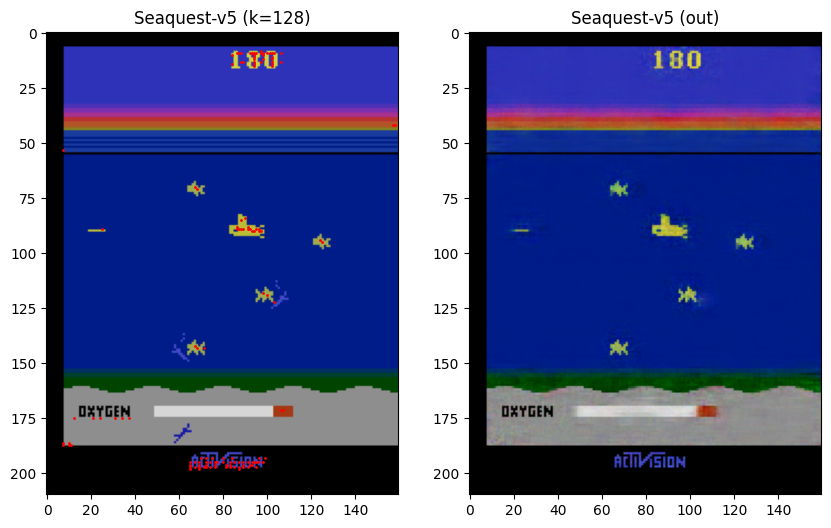

In [23]:
n = len(model.dsets_names)
fig, axs = plt.subplots(n, 2, figsize=(10, 30)) 

# axs[0,0].imshow(plottable_image(inp))
# axs[0,0].set_title(f'Input ({ENV_NAME})')

# new_inp = torch.from_numpy(np.random.random(inp.shape)).float()
# new_inp = torch.from_numpy(np.zeros(inp.shape)).float()

fe_only = model.fe

# Specify seed, to reproduce results
# seed = 12347
# np.random.seed(seed)

for env_name, ax1, ax2 in zip(model.dsets_names, axs.flatten()[0::2], axs.flatten()[1::2]): # Get split odd al even axes
#     input_folder_full = INPUT_FOLDER + f'/{env_name}/val/'
    input_folder_full = INPUT_FOLDER + f'/{env_name}/0/val/'
    filename = np.random.choice(os.listdir(input_folder_full))
    input_path = input_folder_full + filename
    print(filename)
    
    # Load input and obtain outpu
    if input_path.endswith('.npy'):
        print('npy image found')
        inp = load_npy(input_path)
    elif input_path.endswith('.png'):
        print('png image found')
        inp = load_png(input_path)
    out_t = model.forward(inp, env_name)
    
    # Get output of fe
    central = fe_only.forward(inp)
    assert len(central) == 3
    reduced_idx3, reduced_top3, idx = central
#     print(idx)
    hs, ws, _z, _b = unflatten_coords(idx, inp.shape)
    
    
    ax1.imshow(plottable_image(inp))
    ax1.set_title(f'{env_name} (k={idx.shape[-1]})')
    ax2.imshow(plottable_image(out_t))
    ax2.set_title(f'{env_name} (out)')
    
    for h, w in zip(hs, ws):
        ax1.scatter(h, w, s=1, color='red')


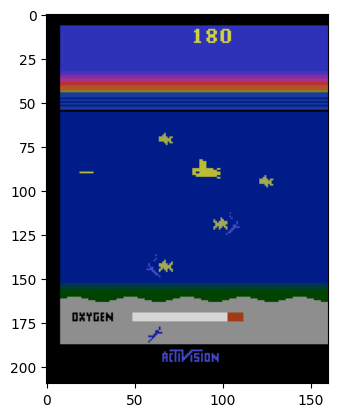

In [24]:
plt.imshow(plottable_image(inp))

In [25]:
for env in model.dsets_names:
    inp_bg = torch.ones(1, 1)
    out_bg = model.dms[env].decoder_dense(inp_bg)
    print(out_bg.shape)
    out_bg = out_bg.reshape(1, 3, 160, 210)
    print(out_bg.shape)

    plt.imshow(plottable_image(out_bg))

AttributeError: 'AE10' object has no attribute 'decoder_dense'